In [2]:
from keras.models import load_model
from tensorflow.keras import backend as K
import tensorflow as tf
import pandas as pd
from glob import glob
import generator as gen
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
import tensorflow as tf
#from keras.applications.resnet50 import ResNet50
from keras.applications.resnet import ResNet50

def dice_coeff(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

def dice_coeff_loss(y_true, y_pred, smooth=100):
    return 1 - dice_coeff(y_true, y_pred, smooth)

data_path_test = "G:\\Harsh_Birva_minor_Proj\\FIVES\\test"

retina_files_test = glob(pathname = data_path_test+'\\Original\\*')
retina_files_test[:1]

mask_files_test = [path.replace('Original', 'Ground truth') for path in retina_files_test]
mask_files_test[:1]

df_test = pd.DataFrame( data = {
    'retina': retina_files_test,
    'mask': mask_files_test
})

batch_size = 1

def dice_score(model, test_gen, num_samples):
    dice_scores = []
    num_batches = num_samples // batch_size
    
    for _ in range(num_batches):
        retina, mask = next(test_gen)
        predictions = model.predict(retina)
        
        batch_dice_scores = []
        for i in range(batch_size):
            dice_score = dice_coeff(mask[i], predictions[i])
            batch_dice_scores.append(dice_score)
        
        batch_mean_dice = np.mean(batch_dice_scores)
        dice_scores.append(batch_mean_dice)
    
    return np.mean(dice_scores)

In [3]:
class ConvBlock(Layer):
    
    def __init__(self, filters=256//4, kernel_size=3, use_bias=False, dilation_rate=1, **kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        
        self.filters = filters
        self.kernel_size = kernel_size
        self.use_bias = use_bias
        self.dilation_rate = dilation_rate
        
        self.net = Sequential([
            Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same', dilation_rate=dilation_rate, use_bias=use_bias, kernel_initializer='he_normal'),
            BatchNormalization(),
            ReLU()
        ])
    
    def call(self, X): return self.net(X)        
        
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "kernel_size":self.kernel_size,
            "use_bias":self.use_bias,
            "dilation_rate":self.dilation_rate
        }

In [4]:
def dice_metric(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred, smooth=100):
    return 1 - dice_coeff(y_true, y_pred, smooth)

In [26]:
test_gen = gen.generate_data_generator(df_test, batch_size=batch_size)

In [27]:
mynet_16 = tf.keras.models.load_model("G:\\Harsh_Birva_minor_Proj\\Fives_script_models\\mynet_16.keras", custom_objects={'dice_coeff': dice_coeff ,'dice_coeff_loss': dice_coeff_loss})
mynet_8 = tf.keras.models.load_model("G:\\Harsh_Birva_minor_Proj\\Fives_script_models\\mynet_8.keras", custom_objects={'dice_coeff': dice_coeff ,'dice_coeff_loss': dice_coeff_loss})
attunet_16 = tf.keras.models.load_model("G:\\Harsh_Birva_minor_Proj\\Fives_script_models\\model_atten_16.keras", custom_objects={'dice_coeff': dice_coeff ,'dice_coeff_loss': dice_coeff_loss})
attunet_8 = tf.keras.models.load_model("G:\\Harsh_Birva_minor_Proj\\Fives_script_models\\model_atten_8.keras", custom_objects={'dice_coeff': dice_coeff ,'dice_coeff_loss': dice_coeff_loss})
simnet_16 = tf.keras.models.load_model("G:\\Harsh_Birva_minor_Proj\\Fives_script_models\\simplenet_16.keras", custom_objects={'dice_coeff': dice_coeff ,'dice_coeff_loss': dice_coeff_loss})
simnet_8 = tf.keras.models.load_model("G:\\Harsh_Birva_minor_Proj\\Fives_script_models\\simplenet_8.keras", custom_objects={'dice_coeff': dice_coeff ,'dice_coeff_loss': dice_coeff_loss})
deeplab = tf.keras.models.load_model("G:\\Harsh_Birva_minor_Proj\\Fives_script_models\\deeplab.keras", custom_objects={'dice_coeff': dice_metric ,'dice_coeff_loss': dice_loss,"ConvBlock":ConvBlock})

In [31]:
mynet_16_branch = tf.keras.models.load_model("G:\\Harsh_Birva_minor_Proj\\New_Fives_models\\mynet_16_branch.keras", custom_objects={'dice_coeff': dice_coeff ,'dice_coeff_loss': dice_coeff_loss})

1/1 [==============================] - 0s 31ms/step


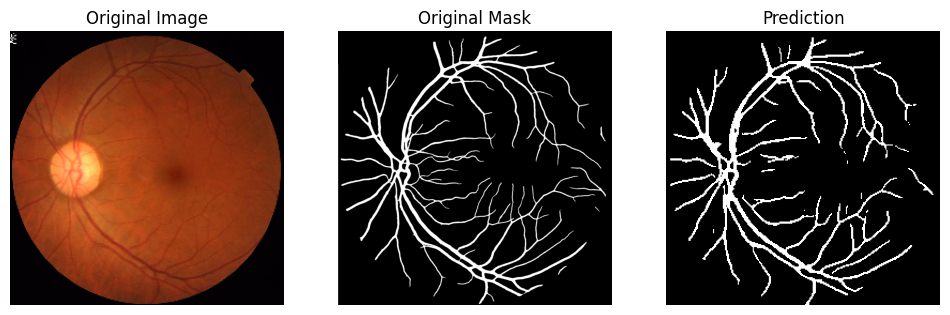

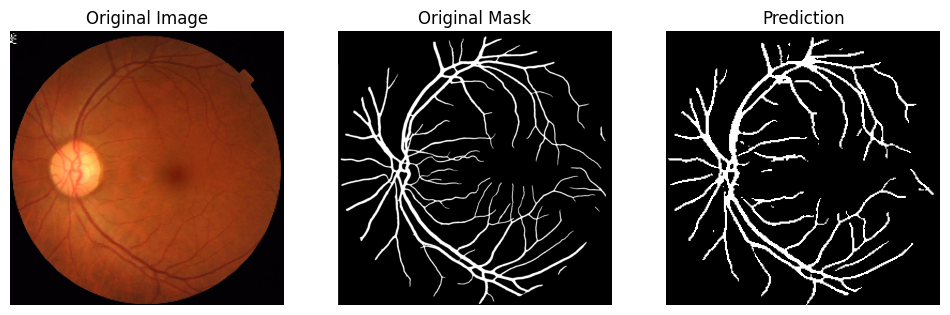

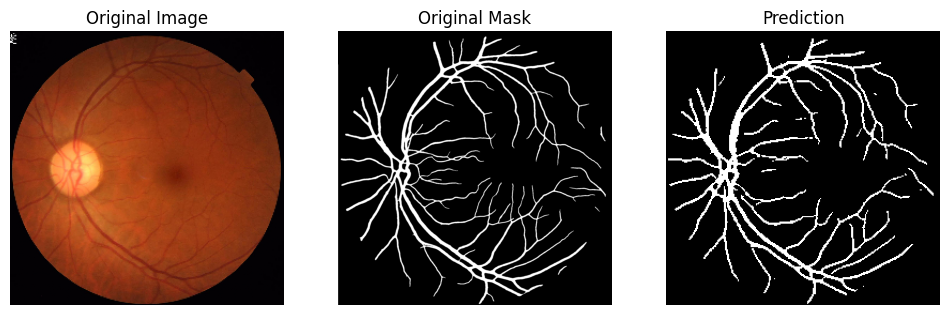

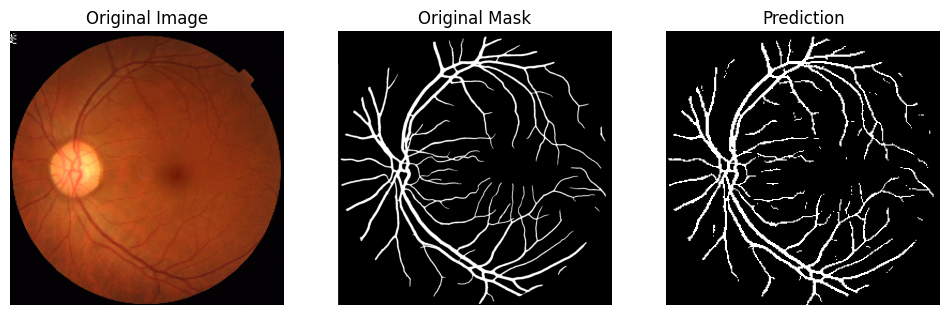

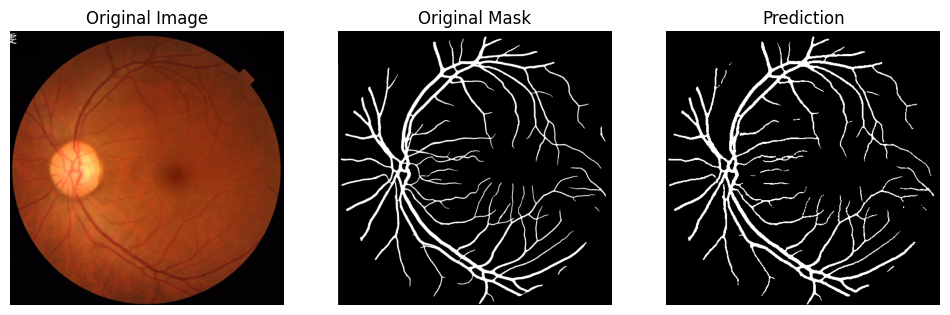

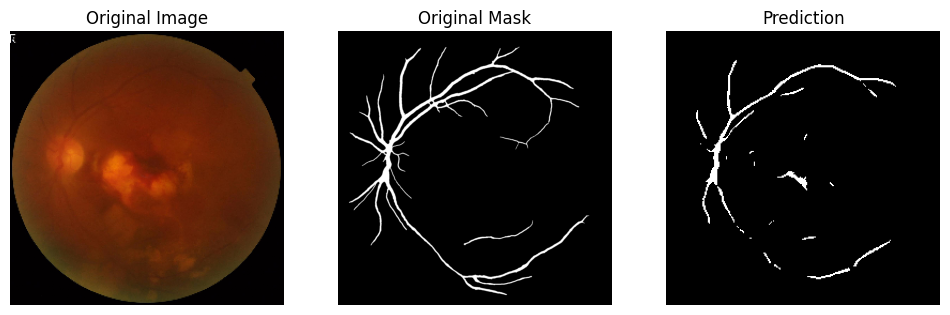

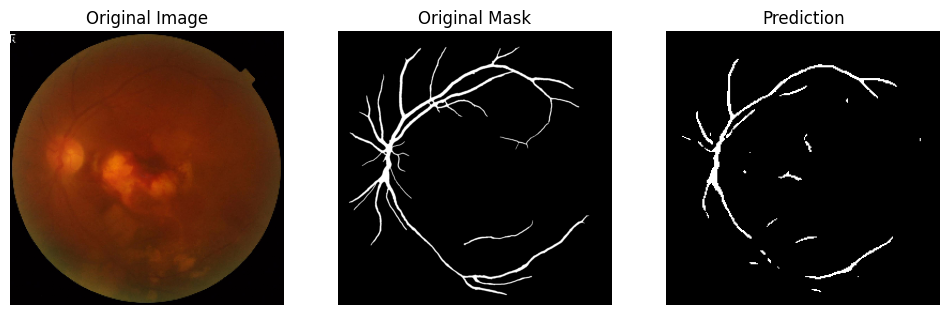

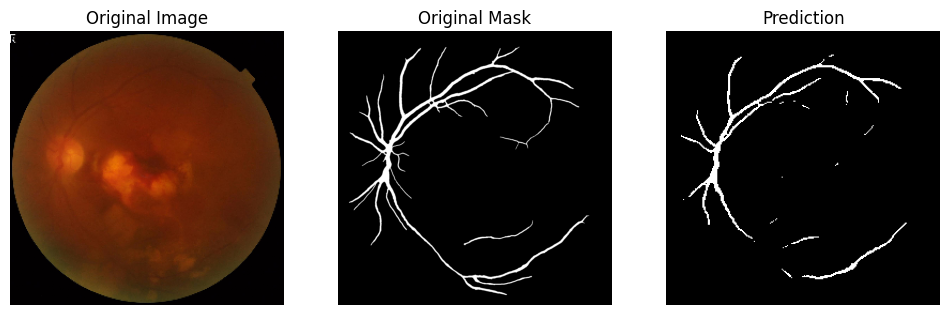

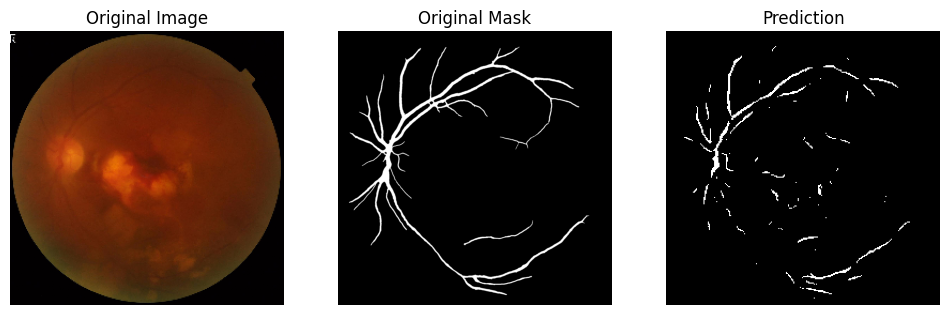

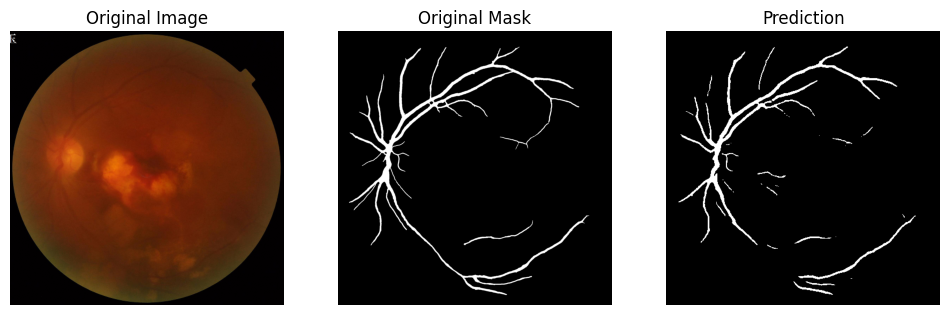

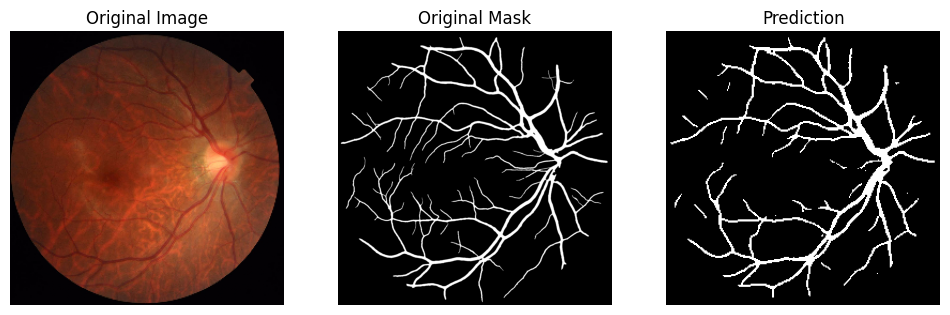

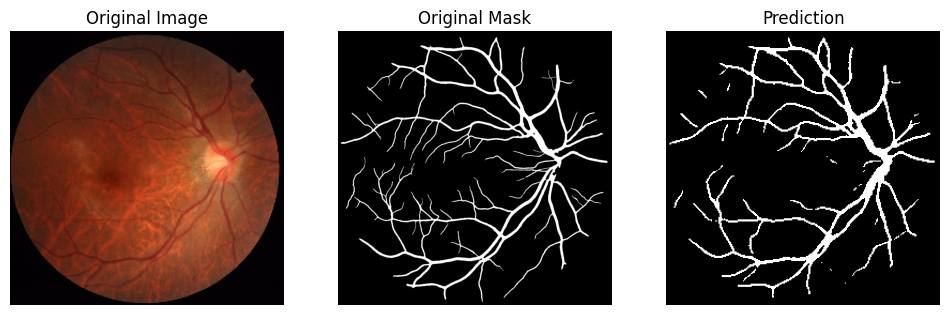

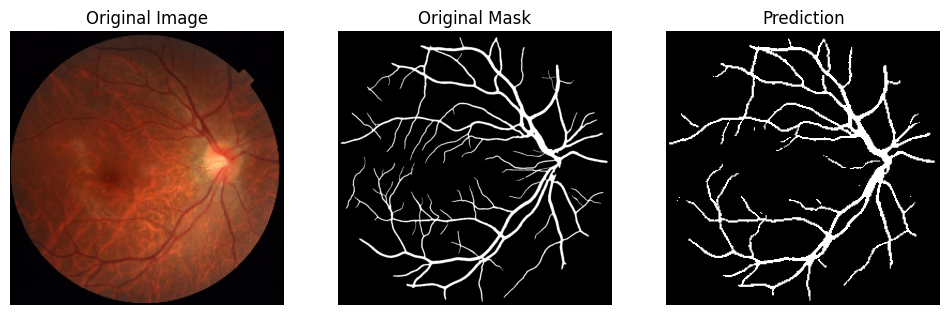

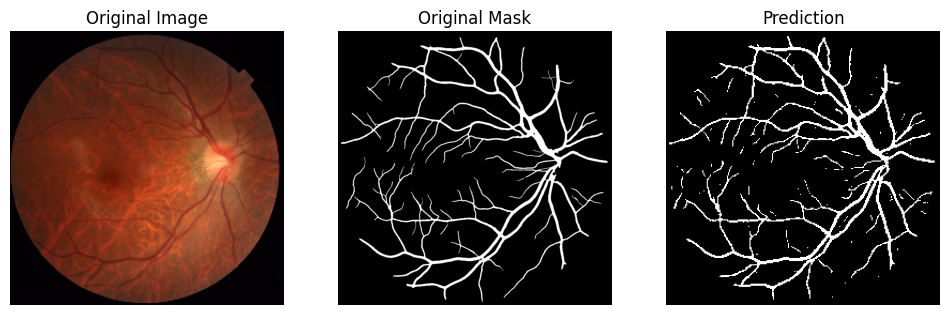

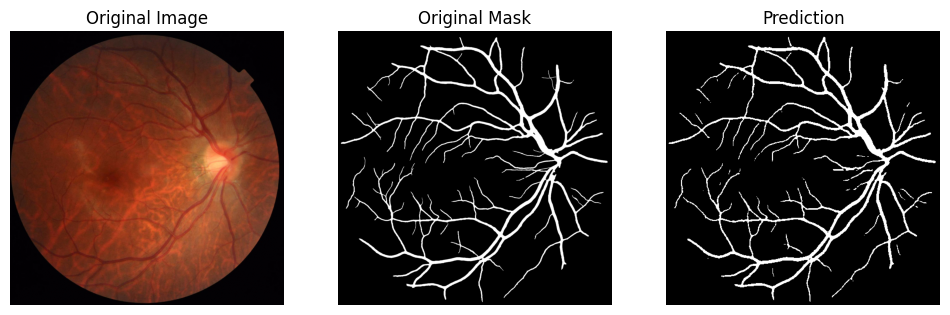

In [50]:
for i in range(3):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['retina'].iloc[index])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256,256))
    img = img/255.0
    img = img[np.newaxis, : ,:, :]
    pred_img = mynet_16.predict(img)
    
    plt.figure(figsize=(12,12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title("Original Image")
    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.axis('off')
    plt.title("Original Mask")
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(pred_img) > 0.5,cmap='gray')
    plt.title("Prediction")
    plt.axis('off')
    
    pred_img = simnet_16.predict(img)
    
    plt.figure(figsize=(12,12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title("Original Image")
    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.axis('off')
    plt.title("Original Mask")
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(pred_img) > 0.5,cmap='gray')
    plt.title("Prediction")
    plt.axis('off')
    
    
    pred_img = attunet_16.predict(img)
    
    plt.figure(figsize=(12,12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title("Original Image")
    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.axis('off')
    plt.title("Original Mask")
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(pred_img) > 0.5,cmap='gray')
    plt.title("Prediction")
    plt.axis('off')
    
    pred_img = mynet_16_branch.predict(img)
    
    plt.figure(figsize=(12,12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title("Original Image")
    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.axis('off')
    plt.title("Original Mask")
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(pred_img) > 0.5,cmap='gray')
    plt.title("Prediction")
    plt.axis('off')
    
    img = cv2.imread(df_test['retina'].iloc[index])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (512,512))
    img = img/255.0
    img = img[np.newaxis, : ,:, :]
    pred_img = deeplab.predict(img)
    
    plt.figure(figsize=(12,12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title("Original Image")
    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.axis('off')
    plt.title("Original Mask")
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(pred_img) > 0.5,cmap='gray')
    plt.title("Prediction")
    plt.axis('off')
plt.show()

In [5]:
res_type = tf.keras.models.load_model("G:\\Harsh_Birva_minor_Proj\\new_retina_models_5\\restype_16-1.keras", custom_objects={'dice_coeff': dice_coeff ,'dice_coeff_loss': dice_coeff_loss})

1/1 [==============================] - 0s 29ms/step


(-0.5, 511.5, 511.5, -0.5)

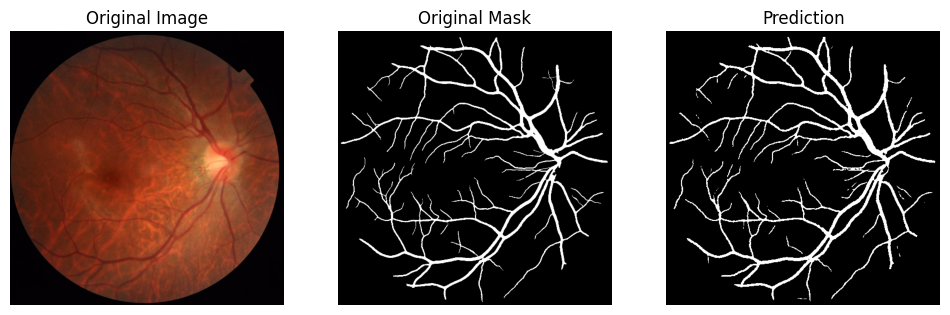

In [9]:
img = cv2.imread("G:\\Harsh_Birva_minor_Proj\\FIVES\\test\\Original\\179_N.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512,512))
img = img/255.0
img = img[np.newaxis, : ,:, :]
pred_img = res_type.predict(img)

plt.figure(figsize=(12,12))
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(img))
plt.axis('off')
plt.title("Original Image")
plt.subplot(1, 3, 2)
plt.imshow(cv2.resize(np.squeeze(cv2.imread("G:\\Harsh_Birva_minor_Proj\\FIVES\\test\\Ground Truth\\179_N.png")),(512,512)))
plt.axis('off')
plt.title("Original Mask")
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(pred_img) > 0.5,cmap='gray')
plt.title("Prediction")
plt.axis('off')

In [10]:
res_type.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   448         ['input_6[0][0]']                
                                16)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   64         ['conv2d[0][0]']                 
 alization)                     16)                                                           

                                                                                                  
 conv2d_15 (Conv2D)             (None, None, None,   2320        ['conv2d_14[0][0]']              
                                16)                                                               
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, None, None,   0          ['conv2d_15[0][0]']              
                                16)                                                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, None, None,   2320        ['max_pooling2d_3[0][0]']        
                                16)                                                               
                                                                                                  
 conv2d_17

 spose)                         16)                                                               
                                                                                                  
 conv2d_31 (Conv2D)             (None, None, None,   2320        ['conv2d_transpose_5[0][0]']     
                                16)                                                               
                                                                                                  
 conv2d_32 (Conv2D)             (None, None, None,   2320        ['conv2d_31[0][0]']              
                                16)                                                               
                                                                                                  
 batch_normalization_7 (BatchNo  (None, None, None,   64         ['conv2d_24[0][0]']              
 rmalization)                   16)                                                               
          

 add_7 (Add)                    (None, None, None,   0           ['add_6[0][0]',                  
                                16)                               'batch_normalization_12[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, None, None,   17          ['add_7[0][0]']                  
                                1)                                                                
                                                                                                  
Total params: 104,209
Trainable params: 103,793
Non-trainable params: 416
__________________________________________________________________________________________________
